In [3]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import spacy
import streamlit as st
import matplotlib.pyplot as plt

In [4]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression



In [5]:
import seaborn as sns

In [6]:
# Download resources
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91720\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91720\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:

df=pd.read_csv(r"C:\Users\91720\OneDrive\Desktop\resume-classifier\Resume\Resume.csv")

In [8]:
# Skill keywords (expandable)
skill_keywords = [
    'python', 'java', 'sql', 'machine learning', 'deep learning',
    'c++', 'c', 'excel', 'tableau', 'nlp', 'django', 'flask',
    'aws', 'azure', 'tensorflow', 'pandas', 'numpy'
]

In [9]:
def clean_text(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower() for token in doc
        if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'PROPN']  # ← BROADER
        and token.text.lower() not in stop_words
        and token.is_alpha
    ]
    return ' '.join(tokens)


In [10]:
# Skill extractor
def extract_skills(text):
    text = text.lower()
    return ' '.join([kw for kw in skill_keywords if kw in text])


In [11]:
# Encode target labels
le = LabelEncoder()
df['Encoded_Category'] = le.fit_transform(df['Category'])


In [12]:
# Apply text cleaning and skill extraction
df['Cleaned_Resume'] = df['Resume_str'].apply(clean_text)
df['Skills_Extracted'] = df['Resume_str'].apply(extract_skills)
df['Final_Text'] = df['Cleaned_Resume'] + ' ' + df['Skills_Extracted']

In [13]:
# lr = LogisticRegression(max_iter=1000, class_weight='balanced')
# lr.fit(X_train_vec, y_train)
# y_pred_lr = lr.predict(X_test_vec)
# print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))

In [14]:
# # from sklearn.tree import DecisionTreeClassifier

# # dt_model = DecisionTreeClassifier()
# dt_model.fit(X_train_vec, y_train)
# y_pred_dt = dt_model.predict(X_test_vec)

# acc_dt = accuracy_score(y_test, y_pred_dt)
# print("Decision Tree Accuracy:", acc_dt)


In [15]:
# Final X and y
X = df['Final_Text']
y = df['Encoded_Category']

In [16]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=20000,   # ← was 15k, try increasing
    ngram_range=(1, 2),
    min_df=2              # ← slightly lower to include more relevant words
)

In [18]:
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [ ]:
xgb_model = XGBClassifier(
    eval_metric='mlogloss',
    n_estimators=400,
    max_depth=7,
    learning_rate=0.08,
    subsample=0.85,
    colsample_bytree=0.85
)
xgb_model.fit(X_train_vec, y_train)
y_pred = xgb_model.predict(X_test_vec)


In [ ]:
print("✅ XGBoost Accuracy:", accuracy_score(y_test, y_pred))

✅ XGBoost Accuracy: 0.8028169014084507


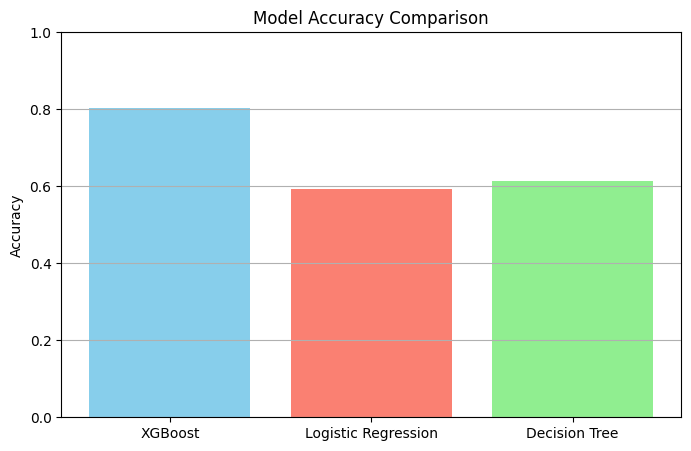

In [ ]:
import matplotlib.pyplot as plt

# Example: Accuracy of multiple models
models = ['XGBoost', 'Logistic Regression', 'Decision Tree']
accuracies = [0.8028, 0.5935, 0.613]  # Replace with actual values

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['skyblue', 'salmon', 'lightgreen'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.grid(axis='y')
plt.show()


In [ ]:
# --- Custom input test ---
sample_resume = input("Paste resume text here:\n")

# Clean and prepare
cleaned = clean_text(sample_resume)
skills = extract_skills(sample_resume)
final_text = cleaned + " " + skills
vectorized = vectorizer.transform([final_text])

# Predict
predicted = xgb_model.predict(vectorized)
predicted_role = le.inverse_transform(predicted)[0]
print("\n✅ Predicted Resume Category:", predicted_role)


NameError: name 'clean_text' is not defined